In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
    width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

In [2]:
from enquire.vendetta import Ophelia

In [3]:
ophelia = Ophelia()


-Ophelia: ¡Hullo! My Name Is Ophelia, I Am Pleased To Meet You     [...]
-Ophelia: I Am An Artificial Assistant For Intelligent Investment  [...]
-Ophelia: Welcome To Your Asset Allocation System                  [...]


-Ophelia: V For VenData                                            [...]

                    - By. Vendetta Gentleman Club -                     

      █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █
      █ █ █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █ █ █
      █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █
      █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █
      █ ╬ ╬ ╬ █ █ █ █ █ █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █ █ █ █ █ █ ╬ ╬ ╬ █
      █ ╬ ╬ █ █ ╬ ╬ ╬ ╬ █ █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █ █ ╬ ╬ ╬ ╬ █ █ ╬ ╬ █
      █ ╬ █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █ ╬ ╬ ╬ ╬ ╬ █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █ ╬ █
      █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █
      █ ╬ ╬ ╬ ╬ █ █ █ █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █ █ █ █ ╬ ╬ ╬ ╬ █
      █ ╬ ╬ █ █ █ 

In [4]:
spk = ophelia.spk
path = "data/master/ophelia/data/OpheliaData/priori_classification"
customer_banking = ophelia.tr.read_file(path, "parquet", spk)

-Ophelia[INFO]: Reading Spark File [...]
-Ophelia[INFO]: Read Parquet Successfully From Path: data/master/ophelia/data/OpheliaData/priori_classification [...]


In [5]:
customer_banking.show(5)

+---+----------+-------+---------+------+-----+------+-------+------+----------+
|age|       job|marital|education|gender|child|saving|insight|backup|risk_label|
+---+----------+-------+---------+------+-----+------+-------+------+----------+
| 59|    admin.|married|secondary|  male|    1|     0|      1|     1|        MC|
| 56|    admin.|married|secondary|female|    0|     1|      0|     1|        MA|
| 41|technician|married|secondary|female|    1|     1|      0|     0|        MA|
| 55|  services|married|secondary|  male|    1|     0|      0|     1|        MA|
| 54|    admin.|married| tertiary|female|    1|     0|      0|     1|        MA|
+---+----------+-------+---------+------+-----+------+-------+------+----------+
only showing top 5 rows



## Se ha decidido aplicar el algoritmo Gradient-Boosted Tree Classifier, la rezón es por tener el potenciador del gradiente descendente, este ha demostrado tener buenos resultados, dado que el algoritmo no soporta clasificación multiclass, se trabajará un tratamiento especial a los datos.

## Se crearán 5 GBTClassifier, uno para cada clase de riesgo {'A', 'MA', 'M', 'MC', 'C'}, convertiremos la clase $k_{i}$ en 1 y el resto en cero.

In [6]:
import numpy as np

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoderEstimator
from pyspark.sql.functions import when, col, lit

In [7]:
mapping_risk_labels = (when(col("risk_label") == "C", lit(1)).otherwise(0))
mapped_classes = customer_banking.select("*", mapping_risk_labels.alias("risk_num"))
mapped_classes.show(5, False)

+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+
|age|job       |marital|education|gender|child|saving|insight|backup|risk_label|risk_num|
+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+
|59 |admin.    |married|secondary|male  |1    |0     |1      |1     |MC        |0       |
|56 |admin.    |married|secondary|female|0    |1     |0      |1     |MA        |0       |
|41 |technician|married|secondary|female|1    |1     |0      |0     |MA        |0       |
|55 |services  |married|secondary|male  |1    |0     |0      |1     |MA        |0       |
|54 |admin.    |married|tertiary |female|1    |0     |0      |1     |MA        |0       |
+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+
only showing top 5 rows



## Bitácora de experimentos:
- para el primer experimento, entrenamos nuestro primer modelo GBTClassifier prediciendo la clase 'C', la distribución es de [1:759, 0:10403], bastante desbalanceada la clase 1, veremos qué resultado arroja el primer modelo a entrenar con este desbalanceo.

In [8]:
mapped_classes.groupBy("risk_num").count().show()

+--------+-----+
|risk_num|count|
+--------+-----+
|       1|  759|
|       0|10403|
+--------+-----+



In [9]:
categorical_columns = ['job', 'marital', 'education', 'gender']

In [10]:
indexers = [StringIndexer(inputCol=column, outputCol="{0}_index".format(column)) for column in categorical_columns]
pipeline = Pipeline(stages=indexers)
fit_model = pipeline.fit(mapped_classes)
transform_df = fit_model.transform(mapped_classes)

transform_df.show(5, False)

+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+---------+-------------+---------------+------------+
|age|job       |marital|education|gender|child|saving|insight|backup|risk_label|risk_num|job_index|marital_index|education_index|gender_index|
+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+---------+-------------+---------------+------------+
|59 |admin.    |married|secondary|male  |1    |0     |1      |1     |MC        |0       |3.0      |0.0          |0.0            |1.0         |
|56 |admin.    |married|secondary|female|0    |1     |0      |1     |MA        |0       |3.0      |0.0          |0.0            |0.0         |
|41 |technician|married|secondary|female|1    |1     |0      |0     |MA        |0       |2.0      |0.0          |0.0            |0.0         |
|55 |services  |married|secondary|male  |1    |0     |0      |1     |MA        |0       |4.0      |0.0          |0.0            |1.0         |

In [11]:
encoder = OneHotEncoderEstimator(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers]
)

In [12]:
encode_vector = encoder.fit(transform_df)
encode_vector_df = encode_vector.transform(transform_df)

In [13]:
encode_vector_df.show(5, False)

+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+---------+-------------+---------------+------------+-----------------+---------------------+-----------------------+--------------------+
|age|job       |marital|education|gender|child|saving|insight|backup|risk_label|risk_num|job_index|marital_index|education_index|gender_index|job_index_encoded|marital_index_encoded|education_index_encoded|gender_index_encoded|
+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+---------+-------------+---------------+------------+-----------------+---------------------+-----------------------+--------------------+
|59 |admin.    |married|secondary|male  |1    |0     |1      |1     |MC        |0       |3.0      |0.0          |0.0            |1.0         |(11,[3],[1.0])   |(2,[0],[1.0])        |(3,[0],[1.0])          |(1,[],[])           |
|56 |admin.    |married|secondary|female|0    |1     |0      |1     |MA        |0       

In [14]:
labeling_deposit = StringIndexer(inputCol='risk_num', outputCol='label')

In [15]:
labeling_string = labeling_deposit.fit(encode_vector_df)
label_df = labeling_string.transform(encode_vector_df)

In [16]:
label_df.show(5, False)

+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+---------+-------------+---------------+------------+-----------------+---------------------+-----------------------+--------------------+-----+
|age|job       |marital|education|gender|child|saving|insight|backup|risk_label|risk_num|job_index|marital_index|education_index|gender_index|job_index_encoded|marital_index_encoded|education_index_encoded|gender_index_encoded|label|
+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+---------+-------------+---------------+------------+-----------------+---------------------+-----------------------+--------------------+-----+
|59 |admin.    |married|secondary|male  |1    |0     |1      |1     |MC        |0       |3.0      |0.0          |0.0            |1.0         |(11,[3],[1.0])   |(2,[0],[1.0])        |(3,[0],[1.0])          |(1,[],[])           |0.0  |
|56 |admin.    |married|secondary|female|0    |1     |0      |1 

In [17]:
string_indexer_cols = []
for c in range(len(indexers)):
    string_indexer_cols.append(indexers[c].getOutputCol())

In [18]:
numericCols = ['age', 'child', 'saving', 'insight', 'backup']
assemblerInputs = string_indexer_cols + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [19]:
assemble_model = assembler.transform(label_df)
assemble_model.show(5, False)

+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+---------+-------------+---------------+------------+-----------------+---------------------+-----------------------+--------------------+-----+--------------------------------------+
|age|job       |marital|education|gender|child|saving|insight|backup|risk_label|risk_num|job_index|marital_index|education_index|gender_index|job_index_encoded|marital_index_encoded|education_index_encoded|gender_index_encoded|label|features                              |
+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+---------+-------------+---------------+------------+-----------------+---------------------+-----------------------+--------------------+-----+--------------------------------------+
|59 |admin.    |married|secondary|male  |1    |0     |1      |1     |MC        |0       |3.0      |0.0          |0.0            |1.0         |(11,[3],[1.0])   |(2,[0],[1.0])        

In [32]:
cols = mapped_classes.columns
selectedCols = ['label', 'features'] + cols
vectorized_customer_banking = assemble_model.select(selectedCols)

In [33]:
vectorized_customer_banking.show(5, False)

+-----+--------------------------------------+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+
|label|features                              |age|job       |marital|education|gender|child|saving|insight|backup|risk_label|risk_num|
+-----+--------------------------------------+---+----------+-------+---------+------+-----+------+-------+------+----------+--------+
|0.0  |[3.0,0.0,0.0,1.0,59.0,1.0,0.0,1.0,1.0]|59 |admin.    |married|secondary|male  |1    |0     |1      |1     |MC        |0       |
|0.0  |(9,[0,4,6,8],[3.0,56.0,1.0,1.0])      |56 |admin.    |married|secondary|female|0    |1     |0      |1     |MA        |0       |
|0.0  |(9,[0,4,5,6],[2.0,41.0,1.0,1.0])      |41 |technician|married|secondary|female|1    |1     |0      |0     |MA        |0       |
|0.0  |[4.0,0.0,0.0,1.0,55.0,1.0,0.0,0.0,1.0]|55 |services  |married|secondary|male  |1    |0     |0      |1     |MA        |0       |
|0.0  |[3.0,0.0,1.0,0.0,54.0,1.0,0.0,0.0,1.0]|54 |admin

In [34]:
train, test = vectorized_customer_banking.randomSplit([0.7, 0.3], seed = 2020)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

print("\nTrain distribution labels")
train.groupBy("risk_label").count().show()

print("Test distribution labels")
test.groupBy("risk_label").count().show()

Training Dataset Count: 7884
Test Dataset Count: 3278

Train distribution labels
+----------+-----+
|risk_label|count|
+----------+-----+
|         M|  283|
|         C|  536|
|         A| 2200|
|        MC| 1596|
|        MA| 3269|
+----------+-----+

Test distribution labels
+----------+-----+
|risk_label|count|
+----------+-----+
|         M|  130|
|         C|  223|
|         A|  897|
|        MC|  680|
|        MA| 1348|
+----------+-----+



## Logistic Regression Model

In [35]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
lrModel = lr.fit(train)

In [36]:
def plot_summary(model):
    beta = np.sort(model.coefficientMatrix)
    plt.plot(beta)
    plt.ylabel('Beta Coefficients')
    plt.show()

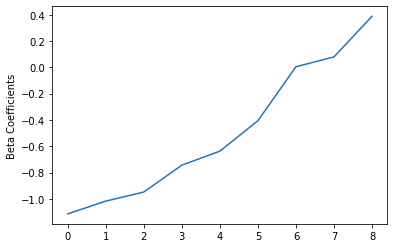

In [37]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

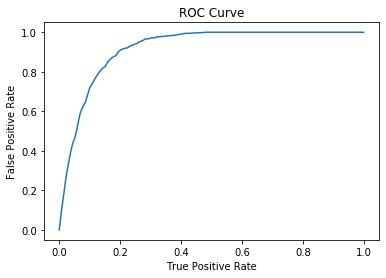

Training set areaUnderROC: 0.9180214029200756


In [38]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

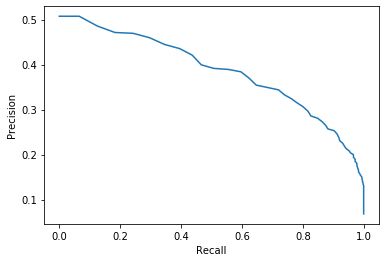

In [39]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [70]:
predict_cols = mapped_classes.columns + ['label', 'prediction', 'probability', 'rawPrediction']
predictions = lrModel.transform(test)
predictions.select(*predict_cols).where(col("risk_label") == "C").show(20, False)

+---+----------+--------+---------+------+-----+------+-------+------+----------+--------+-----+----------+----------------------------------------+--------------------------------------------+
|age|job       |marital |education|gender|child|saving|insight|backup|risk_label|risk_num|label|prediction|probability                             |rawPrediction                               |
+---+----------+--------+---------+------+-----+------+-------+------+----------+--------+-----+----------+----------------------------------------+--------------------------------------------+
|82 |retired   |divorced|tertiary |female|0    |0     |0      |0     |C         |1       |1.0  |1.0       |[0.15315201894985894,0.846847981050141] |[-1.7100901832458124,1.7100901832458124]    |
|76 |retired   |divorced|primary  |female|0    |0     |0      |0     |C         |1       |1.0  |1.0       |[0.2248382600869821,0.775161739913018]  |[-1.237690404586898,1.237690404586898]      |
|54 |retired   |single  |secon

In [56]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8904596596038131


# Exploraremos el valor de la información (iv) y el peso de la evidencia (woe) que aporta cada variable predictora al resultado de la variable dependiente

In [42]:
def __class_mark(observation, min_val, class_length, bins):
    """
    Computes the corresponding bin to a certain data observation given the data set minimum, size, bins
    and the class length
    :param observation: float, value of which is required to obtain your bin number
    :param min_val: float, minimum value observed in the rdd
    :param class_length: float, length of each sub interval
    :param bins: int, number of sub intervals
    :return: int, bin corresponding to the given observation
    """
    interval = int((observation - min_val) / class_length)
    if interval >= bins:
        return bins - 1
    else:
        return interval
    
def __frequency_rdd_continuous(data_set_rdd, min_val, class_length, bins, n):
    """
    Generates the frequency table rdd from certain continuous column rdd

    :param data_set_rdd: rdd, rdd of the continuous column of which the histogram will be computed
    :param min_val: float, minimum value observed in the rdd
    :param class_length: float, length of each sub interval
    :param bins: int, number of sub intervals
    :param n: int, table length
    :return: rdd, rdd containing the frequencies for each class of the histogram
    """
    frequency_rdd = data_set_rdd \
        .map(lambda x: (__class_mark(x, min_val, class_length, bins), 1)) \
        .reduceByKey(lambda x, y: x + y) \
        .map(lambda y: (y[0]+1, min_val+class_length*y[0], min_val+class_length*(y[0]+1), y[1], y[1]/n))
    return frequency_rdd

def __frequency_rdd_discrete(data_set_rdd, n):
    """
    Generates the frequency table rdd from certain discrete column rdd
    :param data_set_rdd: rdd, rdd of the continuous column of which the histogram will be computed
    :param n: int, table length
    :return: rdd, rdd containing the frequencies for each class of the histogram
    """
    frequency_rdd = data_set_rdd \
        .map(lambda r: (r, 1)) \
        .reduceByKey(lambda x, y: x + y) \
        .map(lambda x: (x[0], x[1], x[1] / n))
    return frequency_rdd

def frequency_table_continuous(data_set_df, column, bins=None, suffix=''):
    """
    Computes the histogram frequency table from a column with continuous values for a table Dataframe

    :param data_set_df: Dataframe, table of which it is required to calculate the frequency histogram of some of
    its columns
    :param column: string, column with continuous values which is required to calculate its histogram
    :param bins: int, number of sub intervals
    :param suffix: string, assign the suffix to each column of the frequency table
    :return: Dataframe with the histogram frequency table
    """
    freq_schema = ['bin', 'lower_limit'+suffix, 'upper_limit'+suffix, 'fa_'+column+suffix, 'f_'+column+suffix]
    window_freq = Window.orderBy('bin').rangeBetween(Window.unboundedPreceding, 0)

    cumulative_rel_freq = spark_sum('f_'+column+suffix)\
        .over(window_freq)\
        .alias('F_cumulative_'+column+suffix)

    cumulative_abs_freq = spark_sum('fa_'+column+suffix)\
        .over(window_freq)\
        .alias('Fa_cumulative_'+column+suffix)

    data_set_rdd = data_set_df.select(column).rdd.map(lambda row: (row[0]))
    n = data_set_rdd.count()

    if bins is None:
        bins = 1 + int(3.322 * np.log(n))

    maximum = data_set_rdd.max()
    minimum = data_set_rdd.min()
    class_length = (maximum - minimum) / bins

    frequency_table_df = __frequency_rdd_continuous(data_set_rdd, minimum, class_length, bins, n)\
        .toDF(freq_schema)\
        .select('*', cumulative_abs_freq, cumulative_rel_freq)
    return frequency_table_df

def frequency_table_discrete(data_set_df, column, suffix=''):
    """
    Generates the frequency table rdd from certain discrete column rdd.

    :param data_set_df: Dataframe, table of which it is required to calculate the frequency histogram of some of
    its columns
    :param column: string, column with continuous values ​​which is required to calculate its histogram
    :param suffix: string, assign the suffix to each column of the frequency table
    :return: Dataframe with the histogram frequency table
    """
    freq_schema = ['bin', 'fa_' + column + suffix, 'f_' + column + suffix]
    window_freq = Window.orderBy('bin').rangeBetween(Window.unboundedPreceding, 0)

    cumulative_rel_freq = spark_sum('f_' + column + suffix).over(window_freq).alias(
        'F_cumulative_' + column + suffix)

    cumulative_abs_freq = spark_sum('fa_' + column + suffix).over(window_freq).alias(
        'Fa_cumulative_' + column + suffix)

    data_set_rdd = data_set_df.select(column).rdd.map(lambda row: (row[0]))

    n = data_set_rdd.count()

    frequency_table_df = __frequency_rdd_discrete(data_set_rdd, n)\
        .toDF(freq_schema)\
        .select('*', cumulative_abs_freq, cumulative_rel_freq)
    return frequency_table_df

def compute_information_value(mixed_dist_df, column):
    """
    Calculate the weight of evidence (woe) and the information value (iv) give a table that contains the
    histograms frequency tables of the negative and positive populations.

    :param mixed_dist_df: Dataframe, table with the mixed histograms of negative and positive populations
    :param column: string, column with continuous values which is required to calculate its histogram
    :return: Dataframe, table that includes the woe and iv for each bin inside the histograms
    """
    epsilon = 0.000000001
    woe_expr = spark_log((col('f_' + column + '_0') + epsilon) / (col('f_' + column + '_1') + epsilon))
    iv_expr = (col('f_' + column + '_0') - col('f_' + column + '_1')) * col('woe_' + column)

    iv_table_df = mixed_dist_df\
        .fillna(0)\
        .withColumn('woe_' + column, woe_expr)\
        .withColumn('iv_' + column, iv_expr)\
        .fillna(0, subset=['woe_' + column, 'iv_' + column])\
        .orderBy('bin')
    return iv_table_df

def information_value_continuous(data_set_df, column, target, neg_label=0, pos_label=1, bins=None):
    """
    Computes de frequency table histograms for the negative and positive populations and then compute the
    weight of evidence (woe) and the information value (iv) table.

    :param data_set_df: Dataframe, table of which it is required to calculate the frequency histogram of some of
    its columns
    :param column: string, column with continuous values which is required to calculate its histogram
    :param target: string, target column name that contains observations of negative and positive populations
    :param neg_label: int, value to identify a negative row observation
    :param pos_label: int, value to identify a positive row observation
    :param bins: int, number of sub intervals
    :return: Dataframe, table that includes the woe and iv for each bin of frequency table histogram
    """
    freq_neg_schema = ['bin', 'lower_limit_' + column, 'upper_limit_' + column, 'fa_' + column + '_0', 'f_' + column + '_0']
    freq_pos_schema = ['bin', 'lower_limit_1', 'upper_limit_1', 'fa_' + column + '_1', 'f_' + column + '_1']

    data_set_rdd = data_set_df.select(column).rdd.map(lambda row: (row[0]))
    n = data_set_rdd.count()

    if bins is None:
        bins = 1 + int(3.322 * np.log(n))

    maximum = data_set_rdd.max()
    minimum = data_set_rdd.min()
    class_length = (maximum - minimum) / bins

    lower_lim_expr = (lit(minimum) + lit(class_length) * (col('bin') - lit(1))).alias('lower_limit')
    upper_lim_expr = (lit(minimum) + lit(class_length) * col('bin')).alias('upper_limit')

    neg_rdd = data_set_df\
        .where(col(target) == neg_label)\
        .select(column).rdd\
        .map(lambda row: (row[0]))

    pos_rdd = data_set_df\
        .where(col(target) == pos_label)\
        .select(column).rdd\
        .map(lambda row: (row[0]))

    freq_neg_df = __frequency_rdd_continuous(neg_rdd, minimum, class_length, bins, n)\
        .toDF(freq_neg_schema)\
        .select('bin', 'f_' + column + '_0')

    freq_pos_df = __frequency_rdd_continuous(pos_rdd, minimum, class_length, bins, n)\
        .toDF(freq_pos_schema)\
        .select('bin', 'f_' + column + '_1')

    mixed_dist_df = freq_pos_df.join(freq_neg_df, on='bin', how='full')\
        .select('*', lower_lim_expr, upper_lim_expr)\

    return compute_information_value(mixed_dist_df, column)

def information_value_discrete(data_set_df, column, target, neg_label=0, pos_label=1):
    """
    Computes de frequency table histograms for the negative and positive populations and then compute the
    weight of evidence (woe) and the information value (iv) table.

    :param data_set_df: Dataframe, table of which it is required to calculate the frequency histogram of some of
    its columns
    :param column: string, column with continuous values ​​which is required to calculate its histogram
    :param target: string, target column name that contains observations of negative and positive populations
    :param neg_label: int, value to identify a negative row observation
    :param pos_label: int, value to identify a positive row observation
    :return: Dataframe, table that includes the woe and iv for each bin of frequency table histogram
    """
    freq_neg_schema = ['bin', 'fa_' + column + '_0', 'f_' + column + '_0']
    freq_pos_schema = ['bin', 'fa_' + column + '_1', 'f_' + column + '_1']

    data_set_rdd = data_set_df.select(column).rdd.map(lambda row: (row[0]))
    n = data_set_rdd.count()

    neg_rdd = data_set_df.where(col(target) == neg_label)\
        .select(column).rdd\
        .map(lambda row: (row[0]))

    pos_rdd = data_set_df.where(col(target) == pos_label)\
        .select(column).rdd\
        .map(lambda row: (row[0]))

    freq_neg_df = __frequency_rdd_discrete(neg_rdd, n)\
        .toDF(freq_neg_schema)\
        .select('bin', 'f_' + column + '_0')

    freq_pos_df = __frequency_rdd_discrete(pos_rdd, n)\
        .toDF(freq_pos_schema)\
        .select('bin', 'f_' + column + '_1')

    mixed_dist_df = freq_pos_df\
        .join(freq_neg_df, on='bin', how='full')\
        .fillna(0)
    return compute_information_value(mixed_dist_df, column)

In [47]:
import time
import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from pyspark_dist_explore import hist
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit, sum as spark_sum, log as spark_log

def create_frequency_table(df, coln, targt, function_type):
    f_type = {
        "continuous": information_value_continuous,
        "discrete": information_value_discrete
    }
    
    freq_df = f_type[function_type](data_set_df=df, column=coln, target=targt)
    
    return freq_df

In [53]:
create_frequency_table(predictions, "job", "prediction", "discrete").show(100, False)
create_frequency_table(predictions, "age", "prediction", "continuous").show(100, False)
create_frequency_table(predictions, "education", "prediction", "discrete").show(100, False)
create_frequency_table(predictions, "gender", "prediction", "discrete").show(100, False)

+-------------+---------------------+--------------------+------------------+--------------------+
|bin          |f_job_1              |f_job_0             |woe_job           |iv_job              |
+-------------+---------------------+--------------------+------------------+--------------------+
|admin.       |0.0                  |0.1150091519219036  |18.560522273785608|2.1346299259356845  |
|blue-collar  |0.0                  |0.1815131177547285  |19.01683848869751 |3.4518056439216043  |
|entrepreneur |0.004270896888346553 |0.02410006101281269 |1.730390330202603 |0.03431219385697657 |
|housemaid    |0.007321537522879805 |0.01647345942647956 |0.8109301403367064|0.007421569313636726|
|management   |0.0                  |0.22849298352654057 |19.247016065536357|4.397808124797661   |
|retired      |0.011287370347773032 |0.05491153142159853 |1.5820388678625064|0.06901511839668652 |
|self-employed|6.101281269066504E-4 |0.034472239170225745|4.034239028162587 |0.13660784994693323 |
|services 

## Decision Tree Classifier

In [57]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select(*predict_cols).show(5, False)

+---+-----------+--------+---------+------+-----+------+-------+------+----------+--------+-----+----------+------------------------------------------+
|age|job        |marital |education|gender|child|saving|insight|backup|risk_label|risk_num|label|prediction|probability                               |
+---+-----------+--------+---------+------+-----+------+-------+------+----------+--------+-----+----------+------------------------------------------+
|38 |blue-collar|single  |primary  |female|0    |0     |0      |0     |MA        |0       |0.0  |0.0       |[0.9995726495726496,4.2735042735042735E-4]|
|55 |blue-collar|single  |primary  |female|0    |0     |0      |0     |M         |0       |0.0  |0.0       |[0.9995726495726496,4.2735042735042735E-4]|
|41 |blue-collar|divorced|primary  |female|0    |0     |0      |0     |MA        |0       |0.0  |0.0       |[0.9995726495726496,4.2735042735042735E-4]|
|52 |blue-collar|divorced|primary  |female|0    |0     |0      |0     |M         |0     

In [58]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9895804129083396


## Random Forest Classifier

In [59]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select(*predict_cols).show(5, False)

+---+-----------+--------+---------+------+-----+------+-------+------+----------+--------+-----+----------+-----------------------------------------+
|age|job        |marital |education|gender|child|saving|insight|backup|risk_label|risk_num|label|prediction|probability                              |
+---+-----------+--------+---------+------+-----+------+-------+------+----------+--------+-----+----------+-----------------------------------------+
|38 |blue-collar|single  |primary  |female|0    |0     |0      |0     |MA        |0       |0.0  |0.0       |[0.9885396631599971,0.01146033684000286] |
|55 |blue-collar|single  |primary  |female|0    |0     |0      |0     |M         |0       |0.0  |0.0       |[0.9894401342324765,0.010559865767523546]|
|41 |blue-collar|divorced|primary  |female|0    |0     |0      |0     |MA        |0       |0.0  |0.0       |[0.9902528353928999,0.00974716460710016] |
|52 |blue-collar|divorced|primary  |female|0    |0     |0      |0     |M         |0       |0.0

In [60]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9971486866344227


## Gradient-Boosted Tree Classifier

In [62]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select(*predict_cols).show(10)

+---+-----------+--------+---------+------+-----+------+-------+------+----------+--------+-----+----------+--------------------+
|age|        job| marital|education|gender|child|saving|insight|backup|risk_label|risk_num|label|prediction|         probability|
+---+-----------+--------+---------+------+-----+------+-------+------+----------+--------+-----+----------+--------------------+
| 38|blue-collar|  single|  primary|female|    0|     0|      0|     0|        MA|       0|  0.0|       0.0|[0.93412217565278...|
| 55|blue-collar|  single|  primary|female|    0|     0|      0|     0|         M|       0|  0.0|       0.0|[0.93412217565278...|
| 41|blue-collar|divorced|  primary|female|    0|     0|      0|     0|        MA|       0|  0.0|       0.0|[0.93412217565278...|
| 52|blue-collar|divorced|  primary|female|    0|     0|      0|     0|         M|       0|  0.0|       0.0|[0.93412217565278...|
| 26| technician|  single| tertiary|female|    0|     0|      0|     0|        MA|       0

In [63]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9971031830491807


In [66]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder()\
                .addGrid(gbt.maxDepth, [2, 4, 6])\
                .addGrid(gbt.maxBins, [20, 60])\
                .addGrid(gbt.maxIter, [10, 20])\
                .build()

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)

boosting_predictions = cvModel.transform(test)
evaluator.evaluate(boosting_predictions)

0.9981497655097503

In [69]:
boosting_predictions.select(*predict_cols).where(col("risk_label") == "C").show(1000, False)

+---+----------+--------+---------+------+-----+------+-------+------+----------+--------+-----+----------+-----------------------------------------+
|age|job       |marital |education|gender|child|saving|insight|backup|risk_label|risk_num|label|prediction|probability                              |
+---+----------+--------+---------+------+-----+------+-------+------+----------+--------+-----+----------+-----------------------------------------+
|82 |retired   |divorced|tertiary |female|0    |0     |0      |0     |C         |1       |1.0  |1.0       |[0.04364652142729317,0.9563534785727068] |
|76 |retired   |divorced|primary  |female|0    |0     |0      |0     |C         |1       |1.0  |1.0       |[0.04364652142729317,0.9563534785727068] |
|54 |retired   |single  |secondary|male  |0    |0     |0      |0     |C         |1       |1.0  |1.0       |[0.08767954011207531,0.9123204598879247] |
|26 |unemployed|single  |secondary|male  |0    |0     |0      |0     |C         |1       |1.0  |1.0 